In [ ]:
#!pip install clustergram pandas_profiling scipy sklearn statsmodels IPython dtale matplotlib rpy2 seaborn shap

In [ ]:
#put in ~/.bashrc
#LD_PRELOAD="/mnt/distvol/R/4.1.2/lib64/R/lib/LibR.so"

In [ ]:
#from fracdiff import fdiff
#import urbangrammar-graphics as ugg
%matplotlib inline
import os
from clustergram import Clustergram
from concurrent.futures import wait, ALL_COMPLETED
from dask.distributed import Client
from dask.distributed import as_completed
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from pandas import read_csv
from pandas_profiling import ProfileReport
#from rpy2.robjects import pandas2ri
from pmdarima.utils import diff_inv
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.rinterface_lib import openrlib
from scipy import stats
from scipy.cluster.vq import vq
from scipy.spatial.distance import cdist, pdist
from scipy.special import boxcox, inv_boxcox
from scipy.stats import f
from sklearn import preprocessing
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
#from sklearn.preprocessing import PowerTransformer
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import scale
from sklearn.utils import as_float_array
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import OLSInfluence
import IPython
import concurrent.futures
import dask.dataframe as dd
import datetime
import dtale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg
import pmdarima
import re
import rpy2
import rpy2.robjects as ro
import rpy2.situation
import scipy
import seaborn as sns
import shap
import sklearn
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys
import time

In [ ]:
#c = get_config()
libpath = os.environ.get('LD_LIBRARY_PATH', '')
os.environ['LD_LIBRARY_PATH'] = (
    rpy2.situation.r_ld_library_path_from_subprocess(openrlib.R_HOME) +
    libpath
)

In [ ]:
def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.yeojohnson(x)
        #xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    power = PowerTransformer(method='yeo-johnson')
    power.lambdas_ = lambdas.values
    return(power.inverse_transform([data]))
    #return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.yeojohnson((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def inverse_yeo(og, data_, lambda_):
    values = []
    for i in range(0,len(og)):
        X = og[i]
        X_trans = data_[i]
        if X >= 0 and lambda_ == 0:
            X = exp(X_trans) - 1
        elif X >= 0 and lambda_ != 0:
            X = (X_trans * lambda_ + 1) ** (1 / lambda_) - 1
        elif X < 0 and lambda_ != 2:
            X = 1 - (-(2 - lambda_) * X_trans + 1) ** (1 / (2 - lambda_))
        elif X < 0 and lambda_ == 2:
            X = 1 - exp(-X_trans)
        
        values.append(X)
    return(pd.DataFrame(values))


def revert_yeo (og, data_, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data_.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data_.iloc[:,i]
        else:
            p#ower = PowerTransformer(method='yeo-johnson')
            #power.lambdas_ = lambdas.iloc[i].values
            #revert = pd.DataFrame(power.inverse_transform([data.iloc[:,i].values]))
            #return inv_boxcox(data, lambdas.values)
            revert = pd.DataFrame(inverse_yeo(og.iloc[:,i].values,data_.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data_.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data_.columns
    return reverted

class ZCA(BaseEstimator, TransformerMixin):
  def __init__(self, regularization=1e-5, copy=False):
      self.regularization = regularization
      self.copy = copy
  def fit(self, X, y=None):
      X = as_float_array(X, copy=self.copy)
      self.mean_ = np.mean(X, axis=0)
      X = X - self.mean_
      sigma = np.dot(X.T, X) / (X.shape[0] - 1)
      U, S, V = np.linalg.svd(sigma)
      tmp = np.dot(U, np.diag(1 / np.sqrt(S + self.regularization)))
      self.components_ = np.dot(tmp, U.T)
      return self
  def transform(self, X):
      X_transformed = X - self.mean_
      X_transformed = np.dot(X_transformed, self.components_.T)
      return X_transformed  

'''
def nv_diff_sets(v_of_i,dataset,f_casts):

  s_=sndif_[which(colnames(raw)==var_of_int)]
  d_=ndif_[which(colnames(raw)==var_of_int)]
  
  startRow = c()
  for (r in rownames(dataset[1:d_,,drop=FALSE])):
    startRow = c(startRow,which(rownames(raw)==r))
  
  data_ = c(na.omit(c(dataset[,var_of_int], f_casts)))
  
  if(s_==0):
    inv_d = diffinv(data_,differences=d_,xi=raw[startRow,var_of_int])
  else:  
    inv_d = diffinv(diffinv(data_,differences = d_, xi=raw[startRow,var_of_int]), differences = s_,xi=raw[startRow:(startRow+season-1),var_of_int])
    
  return(inv_d)
'''

def lagpad(x, k):
    length=np.full(abs(k), np.NaN)
    #print(length)
    #k=k-1
    if (k>0):
        result = np.concatenate([length,x[0:(len(x)-k)]])
    elif (k<0):
        result= np.concatenate([(x[abs(k):(len(x))]),length])
    else:
        result= x
    return(result)
   

def lag(data):
    return lagpad(data,1)

def sndif_(npa_):
    data = raw_int[npa_[0]]
    return(pmdarima.arima.nsdiffs(data.dropna(),m=npa_[1]))

def ndif_(npa_):
    data = raw_int[npa_[0]]
    return(pmdarima.arima.ndiffs(data.dropna()))

def clientFunction(function_name,npa):
    client = Client('192.168.3.100:8786',timeout=3)
    future = client.map(function_name,npa)

    results = []
    for f in as_completed(future):
        if(f.status=="error"):
            results.append("error")
        else:
            results.append(f.result())   

    client.close()

    return results

In [ ]:
zca = ZCA()

In [ ]:
raw = pd.read_csv("all_data.csv",index_col=0)
raw.index = pd.to_datetime(raw.index)

#fillna(method='bfill')
raw_int = raw.interpolate(method='time').dropna()


In [ ]:
#delta = (raw_int-raw_int.shift()).dropna()
#raw_delta = (raw_int - raw_int.apply(lag,0)).dropna()
#raw_delta.head()

#raw_delta.isna().sum().sum()

In [ ]:

#for i in range(0,len(raw_int.columns)):
        
#np.max(sndif)

In [ ]:
#raw_int.diff().dropna().apply(pmdarima.arima.nsdiffs(m=4))

sndif = []

season = 4
maxn = season

npa = []

for s in range(0,len(raw_int.columns)):
    npa.append([raw_int.columns[s],maxn, ])
    
sndif = clientFunction(sndif_,npa)    

In [ ]:
ndif = []

npa = []

for s in range(0,len(raw_int.columns)):
    npa.append([raw_int.columns[s]])
    
ndif = clientFunction(ndif_,npa)           

In [ ]:
#doesn't preserve na's...
#len(pmdarima.utils.diff(temp,1,1).ravel())

deseasoned = pd.DataFrame()
for i in range(0,len(raw_int.columns)):
    if(sndif[i]*season == 0):
        temp = raw_int.iloc[:,[i]]
    else:
        temp = raw_int.iloc[:,[i]]
        if(sndif[i]>0):
            for d in range(0,sndif[i]):
                temp = pd.DataFrame(temp.values.ravel()-lagpad(temp.values.ravel(),1*season)).set_index(temp.index)
                temp.columns = raw_int.iloc[:,[i]].columns
    deseasoned = pd.concat([deseasoned,temp],axis=1)


In [154]:

deseasoned_differenced = pd.DataFrame()

for i in range(0,len(raw_int.columns)):
    temp_ = deseasoned.iloc[:,[i]]
    colnames = temp_.columns
    if ndif[i]>0:
        #print(ndif[i])
        for d in range(0,ndif[i]):
            #print(d)
            #
            #print(temp_.columns)
            #temp_ = pd.DataFrame(temp_.values.ravel()-lagpad(temp_.values.ravel(),1)).set_index(temp_.index)
            #temp_.columns = colnames
            temp = temp_.diff()
    deseasoned_differenced = pd.concat([deseasoned_differenced,temp],axis=1)


In [155]:
deseasoned_differenced.fillna(method='bfill').interpolate(method='time').isna().sum().sum()
#.fillna(method='bfill')
#raw_int = raw.dropna()


0

In [156]:
deseasoned_differenced.describe()

,^GSPC,AWHAETP,BAA10Y,BACDINA066MNFRBNY,BACDINA066MNFRBNY,BACDINA066MNFRBNY,BAMLCC0A1AAATRIV,BAMLCC0A4BBBTRIV,BAMLH0A3HYC,BAMLHYH0A0HYM2TRIV,...,WBA,WBEV,WDH,WLTW,WMT,XBOC,XLC,XLF,XLF,^GSPC
count,46.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,50.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,50.000000,50.000000,46.000000
mean,0.013303,0.004938,-0.021673,0.616049,0.616049,0.616049,6.546679,1.594498,-0.092833,18.254586,...,0.163168,-0.790181,1.815607,0.437819,3.710815,1.968394,1.278094,0.385304,0.385304,0.013303
std,6.157150,0.080201,0.453094,16.642048,16.642048,16.642048,13.975538,26.191173,3.406872,37.436962,...,0.237628,7.509236,4.021044,5.716823,7.262683,6.265500,4.274880,5.067154,5.067154,6.157150
min,-15.338084,-0.200000,-1.504410,-64.233333,-64.233333,-64.233333,-25.510096,-45.557100,-9.396154,-139.901796,...,-0.030748,-18.285458,-5.214981,-14.716926,-14.060353,-24.527295,-14.101052,-13.624786,-13.624786,-15.338084
25%,-3.558503,-0.033333,-0.192754,-6.583333,-6.583333,-6.583333,-4.122416,-16.018111,-1.334322,2.758185,...,0.003656,-4.240162,0.074929,-3.164631,-0.645171,0.404115,-0.866302,-1.648113,-1.648113,-3.558503
50%,0.080252,0.000000,-0.033490,0.416667,0.416667,0.416667,7.569685,-6.665457,-0.194841,22.699687,...,0.038907,-0.008206,0.727535,0.851667,2.709435,1.392360,2.303485,0.135944,0.135944,0.080252
75%,2.744062,0.033333,0.144554,6.008333,6.008333,6.008333,15.460935,19.160483,0.917954,34.930997,...,0.224086,3.780755,2.303208,3.786646,5.709335,3.108602,3.711572,2.007001,2.007001,2.744062
max,13.325832,0.233333,2.237218,56.766667,56.766667,56.766667,42.598631,77.887187,17.539328,97.333375,...,0.764248,19.468097,19.203240,13.651029,22.355501,21.235571,11.972997,15.572661,15.572661,13.325832


In [157]:
#https://machinelearningmastery.com/time-series-data-stationary-python/
cleaned = deseasoned_differenced.fillna(method='bfill').interpolate(method='time')


In [158]:
cleaned.apply(adfuller)

,^GSPC,AWHAETP,BAA10Y,BACDINA066MNFRBNY,BACDINA066MNFRBNY,BACDINA066MNFRBNY,BAMLCC0A1AAATRIV,BAMLCC0A4BBBTRIV,BAMLH0A3HYC,BAMLHYH0A0HYM2TRIV,...,WBA,WBEV,WDH,WLTW,WMT,XBOC,XLC,XLF,XLF,^GSPC
0,-1.867014,-4.079966,-4.872032,-3.609422,-3.609422,-3.609422,-5.30328,-5.425751,-5.327561,-5.418641,...,-2.223724,-5.185256,-0.054306,-4.334065,-1.052654,-2.767346,-4.323256,-1.809683,-1.809683,-1.867014
1,0.347734,0.001045,0.00004,0.005583,0.005583,0.005583,0.000005,0.000003,0.000005,0.000003,...,0.197748,0.000009,0.953804,0.000388,0.733579,0.063092,0.000405,0.375665,0.375665,0.347734
2,9,0,8,6,6,6,1,7,0,0,...,1,0,6,5,7,6,9,11,11,9
3,45,54,46,48,48,48,53,47,54,54,...,53,54,48,49,47,48,45,43,43,45
4,"{'1%': -3.584828853223594, '5%': -2.9282991495...","{'1%': -3.55770911573439, '5%': -2.91677034344...","{'1%': -3.5812576580093696, '5%': -2.926784912...","{'1%': -3.5745892596209488, '5%': -2.923954308...","{'1%': -3.5745892596209488, '5%': -2.923954308...","{'1%': -3.5745892596209488, '5%': -2.923954308...","{'1%': -3.560242358792829, '5%': -2.9178502070...","{'1%': -3.5778480370438146, '5%': -2.925338105...","{'1%': -3.55770911573439, '5%': -2.91677034344...","{'1%': -3.55770911573439, '5%': -2.91677034344...",...,"{'1%': -3.560242358792829, '5%': -2.9178502070...","{'1%': -3.55770911573439, '5%': -2.91677034344...","{'1%': -3.5745892596209488, '5%': -2.923954308...","{'1%': -3.5714715250448363, '5%': -2.922629480...","{'1%': -3.5778480370438146, '5%': -2.925338105...","{'1%': -3.5745892596209488, '5%': -2.923954308...","{'1%': -3.584828853223594, '5%': -2.9282991495...","{'1%': -3.5925042342183704, '5%': -2.931549768...","{'1%': -3.5925042342183704, '5%': -2.931549768...","{'1%': -3.584828853223594, '5%': -2.9282991495..."
5,234.958189,-112.416752,1.54019,360.895859,360.895859,360.895859,348.710418,375.609256,173.300884,416.56276,...,-79.679235,291.014985,237.151761,275.726921,296.909803,264.932859,226.967626,252.870953,252.870953,234.958189


(array([[ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([8.320462956918436e-15, 22.900000000000006, 45.800000000000004,
        68.7, 91.60000000000001, 114.50000000000001, 137.39999999999998,
        160.29999999999998, 183.2, 206.1, 229.0], dtype=object),
 <a list of 2 BarContainer objects>)

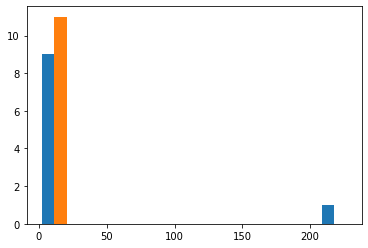

In [159]:
#How many are stationary?
plt.hist(np.histogram(cleaned.apply(adfuller).iloc[1,]))

In [160]:
indexes = train_test_split(cleaned.index, test_size=.4, random_state=0, shuffle=False)

In [161]:
test_sets = []

for i in indexes:
    test_sets.append(cleaned.index.difference(i))

In [ ]:
import pycorrelate

In [162]:
def crosscorrelation(x, y, maxlag, mode='corr'):
    """
    Cross correlation with a maximum number of lags.

    `x` and `y` must be one-dimensional numpy arrays with the same length.

    This computes the same result as
        numpy.correlate(x, y, mode='full')[len(a)-maxlag-1:len(a)+maxlag]

    The return vaue has length 2*maxlag + 1.
    """
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = np.lib.stride_tricks.as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')
    if mode == 'dot':       # get lagged dot product
        return T.dot(px)
    elif mode == 'corr':    # gets Pearson correlation
        return (T.dot(px)/px.size - (T.mean(axis=1)*px.mean())) / \
               (np.std(T, axis=1) * np.std(px))

In [ ]:
#np.cumsum(x_names=='BOGZ1FL105015105Q')

In [ ]:
y_name = cleaned.columns[0]
x_names = cleaned.columns[(cleaned.columns!=cleaned.columns[0])]

for c in cleaned.columns:
    print(y_name)
    y = np.array(cleaned.loc[:,[y_name]]).ravel()
    #print(y)
    for x_ in x_names:
        print(x_)
        x = np.array(cleaned.loc[:,[x_]]).ravel()
        #print(x)
        ccf = statsmodels.tsa.stattools.ccf(x,y)
        #ccf = crosscorrelation(x,y, 4, mode='corr')
        print(ccf)

In [ ]:
from sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

In [ ]:

scaler = StandardScaler()

target = all_data.columns[0]



scaler.fit(np.array(all_data[target]).reshape(-1, 1))

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
kfold.get_n_splits(all_data.index)

exclude = 'States'

sig_table = np.zeros(shape=(len(all_data.columns)))
signs_table = np.zeros(shape=(len(all_data.columns)))

p_threshold = .05

New_Names = all_data.columns[2:]
iteration = 0
for train_index, test_index in kfold.split(all_data):
    #print(iteration)
    max_pvalue = 1
    
    subset = all_data.iloc[train_index].loc[:, ~all_data.columns.isin([exclude])]
    
    #skip y and states
    set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    n=len(subset)
    
    while(max_pvalue>=.05):

        dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        p_values = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()[target]))).T
        p_values.columns = list(subset.columns)
        
        max_pname = p_values.idxmax(axis=1)[0]
        max_pvalue = p_values[max_pname].values[0]
        
        if (max_pvalue > .05):

            set_.remove(max_pname)
            temp = [target]
            temp.extend(set_)
            subset = subset[temp]
    
    winners = p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()
    sig_table = (sig_table + np.where(all_data.columns.isin(winners),1,0)).copy()
    
    signs_table[all_data.columns.get_indexer(winners)]+=np.where(subset.pcorr()[target][winners]<0,-1,1)


significance = pd.DataFrame(sig_table).T
significance.columns = list(all_data.columns)
display(significance)

sign = pd.DataFrame(signs_table).T
sign.columns = list(all_data.columns)
display(sign)

purity = abs((sign/num_folds)*(sign/significance)).T.replace([np.inf, -np.inf, np.NaN], 0)
display(purity.T)

threshold = .5

chosen = list(purity.T.columns.values[np.array(purity.T>=threshold).reshape(len(all_data.columns,))])
dataSet = pd.concat([all_data[target],all_data[chosen]],axis=1)
y_scaled = pd.DataFrame(scaler.transform(np.array(dataSet[target]).reshape(-1, 1)))
y_scaled.columns=[target]

display(chosen)

zca_data = pd.concat([y_scaled,pd.DataFrame(zca.fit_transform(dataSet[chosen]),columns=chosen)],axis=1)

zca_data.pcorr()

sns.pairplot(zca_data)


#model = sklearn.linear_model.LinearRegression()
data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
y = data_set_wConstant[target]
X = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(y,X)
results = model.fit()

results.summary()

pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

plt.scatter(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0])